# ORIE 4741 Project
### Netflix Success Predictor

In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import RocCurveDisplay, recall_score, precision_score, roc_curve, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [326]:
netflix=pd.read_csv('datasets/netflix.csv')

In [327]:
netflix.head()

,show_title,type,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,language,is_staggered_launch,available_globally,release_date,genre,main_production,week
0,'83,Films,6825000.0,NaN,2,NaN,NaN,Non-English,False,No,NaN,NaN,NaN,2022-04-03
1,10 Days of a Bad Man,Films,6900000.0,3300000.0,2,2.0667,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-08-27
2,10 Days of a Good Man,Films,7415000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-03-12
3,1000 Miles from Christmas,Films,6795000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2022-01-02
4,12 Strong,Films,8210000.0,NaN,2,NaN,NaN,English,False,No,NaN,NaN,NaN,2022-07-24


## Feature Engineering
Before we create a model in order to understand the features of importance for Netflix streaming content success and use it to predict how many views a show/film gets, we need to inspect the data and utilize feature engineering tools. 

#### Dealing with simple NaN values: 

In [328]:
def size_if_na_dropped(df):
  print(f"Out of {df.shape[0]} total points, if we drop all with missing data, \
we'll have {df.dropna().shape[0]} points (or {df.dropna().shape[0]/df.shape[0]} \
  of the original dataset)")

size_if_na_dropped(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


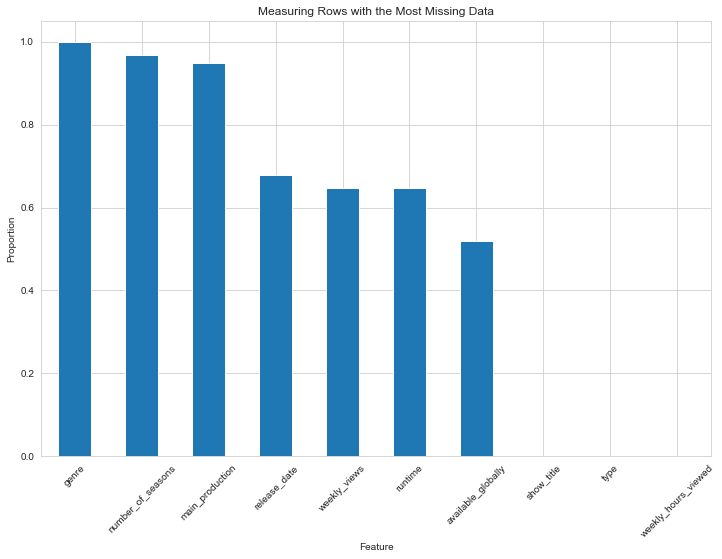

In [329]:
def plot_na(df):
  sns.set_style('whitegrid')
  plt.figure(figsize=(12,8))
  missing_vals = df.isna().sum()/df.shape[0]
  missing_vals = missing_vals.sort_values(ascending=False)[0:10]
  ax = missing_vals.plot(kind='bar')

  ax.set_title('Measuring Rows with the Most Missing Data')
  ax.set_ylabel('Proportion')
  ax.set_xlabel('Feature')
  ax.tick_params(axis='x', rotation=45)

plot_na(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


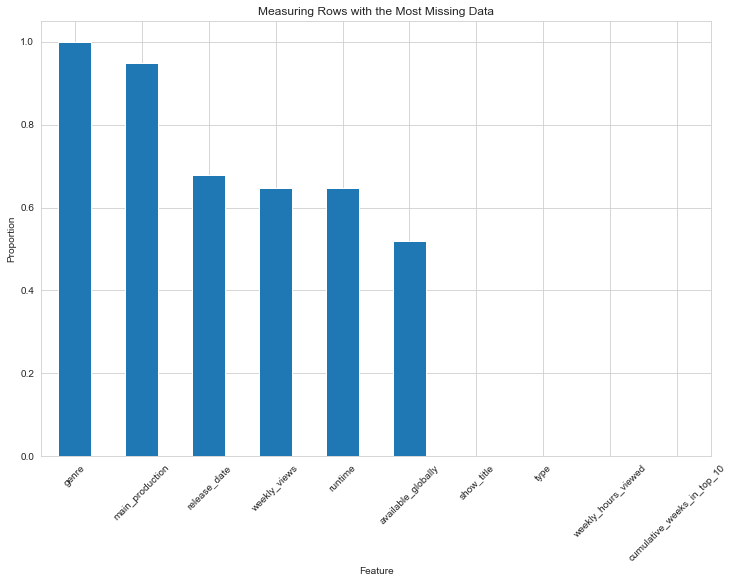

In [330]:
#The NaN values of number_of_seasons occur b/c they are films not shows, impute with 0
netflix['number_of_seasons'] = netflix['number_of_seasons'].fillna(0)
plot_na(netflix)
size_if_na_dropped(netflix)

#### Dealing with Categorical Values
There are a few categorical features in our data. To deal with them we will do the following
- One hot encoding the binary values: Language, Type, Available Globally
- Multi-hot encoding genre list

In [331]:
encoded_df= pd.get_dummies(netflix[['language','type','is_staggered_launch','available_globally' ]])
netflix = pd.concat([netflix.drop(columns=['language','type','is_staggered_launch','available_globally' ]), encoded_df], axis=1)
netflix

,show_title,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,release_date,genre,main_production,week,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,'83,6.825000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-04-03,False,0,1,1,0,1,0
1,10 Days of a Bad Man,6.900000e+06,3300000.0,2,2.0667,0.0,NaN,NaN,NaN,2023-08-27,False,0,1,1,0,0,0
2,10 Days of a Good Man,7.415000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2023-03-12,False,0,1,1,0,0,0
3,1000 Miles from Christmas,6.795000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-01-02,False,0,1,1,0,0,0
4,12 Strong,8.210000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-07-24,False,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,2.400000e+06,1300000.0,1,1.8500,0.0,NaN,NaN,NaN,2024-01-21,False,0,1,1,0,0,0
1861,¡Que viva México!,1.249250e+07,NaN,4,NaN,0.0,2023-05-11,NaN,NaN,2023-06-04,False,0,1,1,0,0,1
1862,Ìjọ̀gbọ̀n,4.950000e+06,2550000.0,2,1.9333,0.0,NaN,NaN,NaN,2023-10-22,False,0,1,1,0,0,0
1863,أصحاب ...ولا أعزّ,2.910000e+06,NaN,3,NaN,0.0,2022-01-20,NaN,NaN,2022-02-06,False,0,1,1,0,1,0


#### Dealing with Missing Data


In [332]:
#Imputing runtime values based on content type
meanfilm=netflix[netflix['type_Films']==1]['runtime'].mean()
netflix.loc[netflix['type_Films'] == 1, 'runtime'] = netflix.loc[netflix['type_Films'] == 1, 'runtime'].fillna(meanfilm)
meantv=netflix[netflix['type_Films']==0]['runtime'].mean()
netflix.loc[netflix['type_Films'] == 0, 'runtime'] = netflix.loc[netflix['type_Films'] == 0, 'runtime'].fillna(meantv)

#Imputing availably globally
netflix['available_globally_Yes'] = netflix.apply(lambda row: True if row['language_Non-English'] == True else row['available_globally_Yes'], axis=1)

In [333]:
netflix

,show_title,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,release_date,genre,main_production,week,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,'83,6.825000e+06,NaN,2,1.838932,0.0,NaN,NaN,NaN,2022-04-03,False,0,1,1,0,1,True
1,10 Days of a Bad Man,6.900000e+06,3300000.0,2,2.066700,0.0,NaN,NaN,NaN,2023-08-27,False,0,1,1,0,0,True
2,10 Days of a Good Man,7.415000e+06,NaN,2,1.838932,0.0,NaN,NaN,NaN,2023-03-12,False,0,1,1,0,0,True
3,1000 Miles from Christmas,6.795000e+06,NaN,2,1.838932,0.0,NaN,NaN,NaN,2022-01-02,False,0,1,1,0,0,True
4,12 Strong,8.210000e+06,NaN,2,1.838932,0.0,NaN,NaN,NaN,2022-07-24,False,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,2.400000e+06,1300000.0,1,1.850000,0.0,NaN,NaN,NaN,2024-01-21,False,0,1,1,0,0,True
1861,¡Que viva México!,1.249250e+07,NaN,4,1.838932,0.0,2023-05-11,NaN,NaN,2023-06-04,False,0,1,1,0,0,True
1862,Ìjọ̀gbọ̀n,4.950000e+06,2550000.0,2,1.933300,0.0,NaN,NaN,NaN,2023-10-22,False,0,1,1,0,0,True
1863,أصحاب ...ولا أعزّ,2.910000e+06,NaN,3,1.838932,0.0,2022-01-20,NaN,NaN,2022-02-06,False,0,1,1,0,1,True


In [334]:
from sklearn.impute import SimpleImputer

In [335]:
Y=netflix[['weekly_hours_viewed', 'weekly_views',
       'cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons',
       'is_staggered_launch', 'language_English', 'language_Non-English',
       'type_Films', 'type_TV', 'available_globally_No',
       'available_globally_Yes']].to_numpy()

In [336]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
Y_imputed = imputer.fit_transform(Y)

pca = PCA(n_components=3)
Y_pca = pca.fit_transform(Y_imputed)


In [337]:
Y_completed = pca.inverse_transform(Y_pca)

In [338]:
Y_completed

array([[6.82500000e+06, 3.86786472e+06, 2.06809225e+00, ...,
        2.30300387e-01, 2.30525745e-01, 6.44715794e-01],
       [6.90000000e+06, 3.30000000e+06, 2.06252662e+00, ...,
        2.74518168e-01, 2.23226982e-01, 6.80113022e-01],
       [7.41500000e+06, 3.86786472e+06, 2.06810168e+00, ...,
        2.43440102e-01, 2.27070860e-01, 6.44183128e-01],
       ...,
       [4.95000000e+06, 2.55000000e+06, 2.05722338e+00, ...,
        2.87278011e-01, 2.25589583e-01, 7.28785549e-01],
       [2.91000000e+06, 3.86786472e+06, 3.04997091e+00, ...,
        1.40128166e-01, 2.55159452e-01, 6.82311769e-01],
       [5.46333333e+06, 3.86786472e+06, 3.05749189e+00, ...,
        1.96969975e-01, 2.40220817e-01, 6.80266030e-01]])

In [339]:
netflix = pd.DataFrame(Y_completed, columns=['weekly_hours_viewed', 'weekly_views',
                                                  'cumulative_weeks_in_top_10', 'runtime', 
                                                  'number_of_seasons', 'is_staggered_launch', 
                                                  'language_English', 'language_Non-English', 
                                                  'type_Films', 'type_TV', 
                                                  'available_globally_No', 'available_globally_Yes'])
netflix.head()

,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,6825000.0,3.867865e+06,2.068092,2.423048,0.050743,0.003761,0.456861,0.543139,0.769700,0.230300,0.230526,0.644716
1,6900000.0,3.300000e+06,2.062527,2.592611,0.066840,0.005869,0.438188,0.561812,0.725482,0.274518,0.223227,0.680113
2,7415000.0,3.867865e+06,2.068102,2.480854,0.057153,0.003831,0.466361,0.533639,0.756560,0.243440,0.227071,0.644183
3,6795000.0,3.867865e+06,2.066275,2.420134,0.050393,0.003752,0.456469,0.543531,0.770362,0.229638,0.230698,0.644680
4,8210000.0,3.867865e+06,1.937978,2.560496,0.064046,0.003546,0.485696,0.514304,0.738459,0.261541,0.222189,0.638951


In [340]:
netflix['is_staggered_launch'] = netflix['is_staggered_launch'].round().astype(int)
netflix['language_English'] = netflix['language_English'].round().astype(int)
netflix['language_Non-English'] = netflix['language_Non-English'].round().astype(int)
netflix['type_Films'] = netflix['type_Films'].round().astype(int)
netflix['type_TV'] = netflix['type_TV'].round().astype(int)
netflix['available_globally_No'] = netflix['available_globally_No'].round().astype(int)
netflix['available_globally_Yes'] = netflix['available_globally_Yes'].round().astype(int)

In [341]:
netflix

,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,6.825000e+06,3.867865e+06,2.068092,2.423048,0.050743,0,0,1,1,0,0,1
1,6.900000e+06,3.300000e+06,2.062527,2.592611,0.066840,0,0,1,1,0,0,1
2,7.415000e+06,3.867865e+06,2.068102,2.480854,0.057153,0,0,1,1,0,0,1
3,6.795000e+06,3.867865e+06,2.066275,2.420134,0.050393,0,0,1,1,0,0,1
4,8.210000e+06,3.867865e+06,1.937978,2.560496,0.064046,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1860,2.400000e+06,1.300000e+06,1.055179,2.736313,0.058545,0,0,1,1,0,0,1
1861,1.249250e+07,3.867865e+06,4.069879,2.951414,0.139132,0,0,1,1,0,0,1
1862,4.950000e+06,2.550000e+06,2.057223,2.615772,0.065868,0,0,1,1,0,0,1
1863,2.910000e+06,3.867865e+06,3.049971,2.026267,0.021367,0,0,1,1,0,0,1


## Modeling
Now that the feature engineering is completed. We will explore different models to find the best fit to predict our success variable
We will explore
- Linear Regression
- Polynomial Fits
- Regression Trees

In [342]:
#Linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y = netflix["weekly_hours_viewed"]
X = netflix.copy().drop(['weekly_hours_viewed'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("shape of X_train ", X_train.shape)
print("shape of y_train ", y_train.shape)
print("shape of X_test ", X_test.shape)
print("shape of y_test ", y_test.shape)



shape of X_train  (1492, 11)
shape of y_train  (1492,)
shape of X_test  (373, 11)
shape of y_test  (373,)


In [343]:
X_train

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
898,3.500000e+06,0.937606,2.442858,0.034410,0,0,1,1,0,0,1
244,3.867865e+06,0.934975,2.312385,0.021602,0,0,1,1,0,0,1
710,4.900000e+06,0.948527,2.317310,0.027114,0,1,0,1,0,0,1
1190,3.867865e+06,3.042419,3.450949,0.179223,0,1,0,1,0,0,1
720,3.867865e+06,1.035509,2.809734,0.078245,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1130,3.867865e+06,6.105280,9.475661,0.892843,0,1,0,-1,2,0,1
1294,3.867865e+06,0.907707,3.024062,0.100107,0,1,0,1,0,0,1
860,4.190000e+06,6.921874,4.969796,0.406879,0,1,0,0,1,0,1
1459,3.867865e+06,13.052233,5.834653,0.592560,0,0,1,0,1,0,1


In [344]:
linear_model = LinearRegression(fit_intercept=True).fit(X_train,y_train)
linear_pred = linear_model.predict(X_train)

In [345]:
#Vizualizations for the linear model made 

def plot_predicted_v_actual(y_train, y_pred):
  #helps us understand the relationship between the predicted and the actual values
  plt.scatter(y_train, y_pred)
  plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')
  plt.show()
  

def plot_residuals (y, y_pred):
  residuals = y - y_pred
  plt.scatter(y_pred, residuals)
  plt.xlabel("Predicted Values")
  plt.ylabel("Residuals")
  plt.title("Residual Plot")
  plt.axhline(y=0, color='r', linestyle='-')
  plt.show()


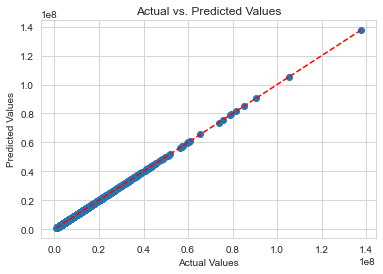

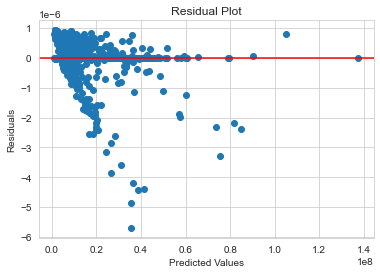

In [346]:
plot_predicted_v_actual(y_train, linear_pred)
plot_residuals(y_train, linear_pred)


The residual plot informs us that the residual (difference between the predicted and actual value) increases as the predicted values increases in size. This is a symptom of heteroscedasticity (https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/). Hence, we will employ regression techinques to reduce this. 

We can also observe a clear downwards trend within the residual graph which hints at the presence of a non-linear relationship in the dataset hence, prompting us to attempt polynomial fits as well. It is possible that multicolinearity is present within the dataset

In [347]:
from sklearn.metrics import r2_score, mean_squared_error
#calculating the R-squared score 
r_squared_lin = r2_score(y_train, linear_pred)
print("linear R^2 score: ", r_squared_lin)

#calculating the mean squared error(MSE)
mse_lin = mean_squared_error(y_train, linear_pred)
print("linear MSE score: ", r_squared_lin)

#https://www.geeksforgeeks.org/cross-validation-machine-learning/
from sklearn.model_selection import cross_val_score, KFold
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results_lin = cross_val_score(LinearRegression(), X_train, y_train, cv=kf)
print(f'Cross-Validation Results (Accuracy): {cross_val_results_lin}')
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_results_lin.mean(), cross_val_results_lin.std()))



linear R^2 score:  1.0
linear MSE score:  1.0
Cross-Validation Results (Accuracy): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.00 accuracy with a standard deviation of 0.00


Testing for the presence of mulitcolinearity as per https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Multicollinearity%20is%20a%20statistical%20phenomenon,relationship%20among%20the%20predictor%20variables.
using the VIF value 
https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/#

In [348]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# calculating VIF for each feature 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                          for i in range(len(X_train.columns))] 


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [349]:
vif_data

,feature,VIF
0,weekly_views,inf
1,cumulative_weeks_in_top_10,inf
2,runtime,inf
3,number_of_seasons,inf
4,is_staggered_launch,NaN
5,language_English,inf
6,language_Non-English,inf
7,type_Films,inf
8,type_TV,inf
9,available_globally_No,1.135937


It is clear that multiple features have high multicolinearity hence we will employ PCA to tackle this issue

In [350]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale data before applying PCA
scaling=StandardScaler()

# Use fit and transform method 
scaling.fit(X_train)
Scaled_data=scaling.transform(X_train)
 
# Set the n_components=3
principal=PCA(n_components=7)
principal.fit(Scaled_data)
x_train_after_pca =principal.transform(Scaled_data)

# Check the dimensions of data after PCA
print(x_train_after_pca.shape)

# check how much variance is explained by each principal component
print(principal.explained_variance_ratio_)




(1492, 7)
[0.43667217 0.23655448 0.12827328 0.09591366 0.05701215 0.02748365
 0.01809061]


Retraining after the PCA reduced dimensionality to 7 features 

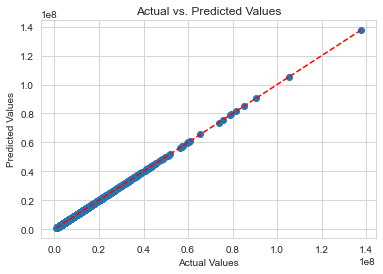

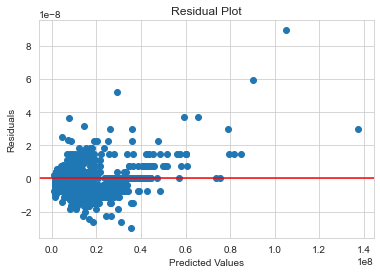

In [351]:
linear_model_after_pca = LinearRegression(fit_intercept=True).fit(x_train_after_pca,y_train)
linear_pred_after_pca = linear_model_after_pca.predict(x_train_after_pca)

plot_predicted_v_actual(y_train, linear_pred_after_pca)
plot_residuals(y_train, linear_pred_after_pca)

Now we proceed onto generalization 

In [352]:
(x_train_after_pca == 0).sum().sum()
# this means that the modified dataset is not sparse 

0

In [353]:

print(x_train_after_pca.shape)

(1492, 7)


In [354]:
vif_data_pca = pd.DataFrame() 
vif_data_pca["VIF"] = [variance_inflation_factor(x_train_after_pca, i) 
                          for i in range(len(x_train_after_pca[0]))] 

In [355]:
vif_data_pca

,VIF
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0


In [356]:
#calculating the R-squared score 
r_squared_lin = r2_score(y_train, linear_pred_after_pca)
print("linear R^2 score: ", r_squared_lin)

#calculating the mean squared error(MSE)
mse_lin = mean_squared_error(y_train, linear_pred_after_pca)
print("linear MSE score: ", r_squared_lin)

#https://www.geeksforgeeks.org/cross-validation-machine-learning/
num_folds_pca = 500
kf_pca = KFold(n_splits = num_folds_pca, shuffle = True, random_state = 42)
cross_val_results_lin_after_pca = cross_val_score(LinearRegression(), x_train_after_pca, y_train, cv = kf_pca)
print(f'PCA Cross-Validation Results (Accuracy): {cross_val_results_lin_after_pca}')
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_results_lin_after_pca.mean(), cross_val_results_lin_after_pca.std()))

linear R^2 score:  1.0
linear MSE score:  1.0
PCA Cross-Validation Results (Accuracy): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 


# We should ask about the fix to heteroscedasticity faced - doesnt seem to simple??

/Applications/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


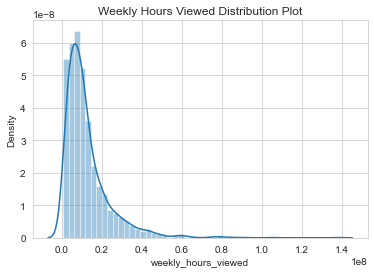

In [357]:
# Data distribution
plt.title('Weekly Hours Viewed Distribution Plot')
sns.distplot(netflix['weekly_hours_viewed'])
plt.show()

In [358]:
y = (netflix["weekly_hours_viewed"]).values
X = (netflix.copy().drop(['weekly_hours_viewed'], axis=1)).values

In [359]:
y

array([6824999.9999999 , 6899999.99999992, 7414999.99999991, ...,
       4949999.99999991, 2909999.99999996, 5463333.33333326])

In [360]:
X

array([[3.86786472e+06, 2.06809225e+00, 2.42304837e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.30000000e+06, 2.06252662e+00, 2.59261134e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.86786472e+06, 2.06810168e+00, 2.48085446e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [2.55000000e+06, 2.05722338e+00, 2.61577237e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.86786472e+06, 3.04997091e+00, 2.02626702e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.86786472e+06, 3.05749189e+00, 2.27633291e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [362]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
 
pr = PolynomialFeatures(degree = 4)
X_poly = pr.fit_transform(X_train)
lr_2 = LinearRegression()
lr_2.fit(X_poly, y_train)
#Predict results
y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
#lr_2.fit(pr.fit_transform(X_test), y_test)
y_test_pred_poly = lr_2.predict(pr.fit_transform(X_test))


In [363]:
def poly_plot_predicted_v_actual(y_train, y_pred):
  #helps us understand the relationship between the predicted and the actual values
  plt.scatter(y_train, y_pred)
  plt.plot(y_train, lr_2.predict(pr.fit_transform(X_train)), color = 'firebrick', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')
  plt.show()

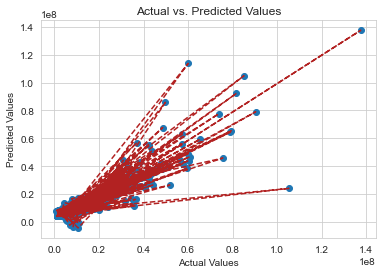

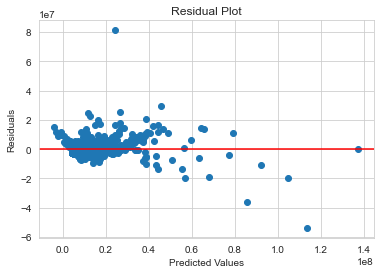

In [364]:
poly_plot_predicted_v_actual(y_train, y_pred_poly)
plot_residuals(y_train, y_pred_poly)

In [365]:
# This function just computes the mean squared error
def MSE(y, pred):
    return np.square(np.subtract(y,pred)).mean()

In [366]:
# linear train and test MSE
linear_test_pred = linear_model.predict(X_test)

linear_train_MSE = MSE(y_train, linear_pred.flatten())
linear_test_MSE = MSE(y_test, linear_test_pred.flatten())
print("Linear Train MSE\t", str(linear_train_MSE))
print("Linear Test MSE\t", str(linear_test_MSE))
linear_train_PCA_MSE = MSE(y_train, linear_pred_after_pca.flatten())
print("Linear Train with PCA MSE\t", str(linear_train_PCA_MSE))

Linear Train MSE	 2.8974308035311336e-13
Linear Test MSE	 5.312626223287795e-13
Linear Train with PCA MSE	 6.073450593355394e-17


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [367]:
# polynomial train and test MSE at degree 4
poly_train_MSE = MSE(y_train, y_pred_poly.flatten())
print("Polynomial Train MSE\t", str(poly_train_MSE))
poly_test_MSE = MSE(y_test, y_test_pred_poly.flatten())
print("Polynomial Train MSE\t", str(poly_test_MSE))

Polynomial Train MSE	 21919475903713.875
Polynomial Train MSE	 297594919107455.25


In [368]:
# compare train and test MSE for polynomials of degrees 1-7
for i in range(7):
  pr = PolynomialFeatures(degree = i+1)
  X_poly = pr.fit_transform(X_train)
  lr_2 = LinearRegression()
  lr_2.fit(X_poly, y_train)
  #Predict results
  y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
  y_test_pred_poly = lr_2.predict(pr.fit_transform(X_test))
  
  poly_train_MSE = MSE(y_train, y_pred_poly.flatten())
  print(("Polynomial Train MSE" + " at degree " + str(i+1) + "\t"), str(poly_train_MSE))
  poly_test_MSE = MSE(y_test, y_test_pred_poly.flatten())
  print(("Polynomial Test MSE" + " at degree " + str(i+1) + "\t"), str(poly_test_MSE))


Polynomial Train MSE at degree 1	 1.6179424031546981e-15
Polynomial Test MSE at degree 1	 2.819995317093611e-15
Polynomial Train MSE at degree 2	 272016242454.78656
Polynomial Test MSE at degree 2	 1045469788929.7058
Polynomial Train MSE at degree 3	 4008944376380.2554
Polynomial Test MSE at degree 3	 271632630900687.78
Polynomial Train MSE at degree 4	 21919475903713.875
Polynomial Test MSE at degree 4	 297594919107455.25
Polynomial Train MSE at degree 5	 49047993168780.35
Polynomial Test MSE at degree 5	 1.946029262547618e+16
Polynomial Train MSE at degree 6	 90614007626062.62
Polynomial Test MSE at degree 6	 1.7696511675668906e+17
Polynomial Train MSE at degree 7	 101080086053467.84
Polynomial Test MSE at degree 7	 7.071693435325019e+17
